In [1]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
def compute_ploidy(df):
    reds = (df["color"] == "red").sum()
    greens = (df["color"] == "green").sum()

    return reds, greens

def filter_by_ploidy(df, min_ploidy):
    if min_ploidy < 1:
        return df
    dfs = []

    for cell, dff in df.groupby("cell"):
        dff1 = dff[dff["color"] == "red"]
        dff2 = dff[dff["color"] == "green"]

        if len(dff1) < min_ploidy or len(dff2) < min_ploidy:
            continue

        dff["cell"] = cell
        dfs.append(dff)

    return pd.concat(dfs)

def import_data(path, min_ploidy):
    df = filter_by_ploidy(pd.read_table(path), min_ploidy)

    dfs = []

    for cell, dff in df.groupby("cell"):
        dff1 = dff[dff["color"] == "red"]
        dff2 = dff[dff["color"] == "green"]
        
        dff = dff1.merge(dff2, how="cross", suffixes=("1", "2")).drop(columns=["cell1", "cell2"])
        dff["cell"] = cell
        dfs.append(dff)

    df = pd.concat(dfs)

    df["distance"] = np.sqrt(np.power(df["x1"] - df["x2"], 2) + np.power(df["y1"] - df["y2"], 2))

    dfs = []

    for _, dff in df.groupby(["cell", "x1", "y1"]):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])

    return pd.concat(dfs)


def plot_distance_distribution(df, ax, label, xmin=None, xmax=None):
    dfs = []
    for _, dff in df.groupby(["x1", "y1", "cell"]):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])

    dff = pd.concat(dfs)
 
    if xmin is None:
        xmin = 0
    if xmax is None:
        xmax = dff["distance"].max()

    ax.hist(dff["distance"], bins=50, label=label, density=True, range=(xmin, xmax), alpha=0.5)
    
    return dff


def plot_distance_distribution_boxplot(df1, df2, df3, df4, ax, label1, label2, label3, label4):
    dfs = []
    for _, dff in df1.groupby(["x1", "y1", "cell"]):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])
    dff1 = pd.concat(dfs)
    
    dfs = []
    for _, dff in df2.groupby(["x1", "y1", "cell"]):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])
    dff2 = pd.concat(dfs)

    dfs = []
    for _, dff in df3.groupby(["x1", "y1", "cell"]):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])
    dff3 = pd.concat(dfs)
    
    dfs = []
    for _, dff in df4.groupby(["x1", "y1", "cell"]):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])
    dff4 = pd.concat(dfs)
    
    dff1["condition"] = label1
    dff2["condition"] = label2
    dff3["condition"] = label3
    dff4["condition"] = label4

    dff = pd.concat([dff1, dff2, dff3, dff4])

    
    palette = {
        "10A (AD)": "tab:blue",
        "10A (AE)": "tab:blue",
        "C1 (AD)": "tab:green",
        "C1 (AE)": "tab:green",
        
    }

    sns.boxplot(dff, x="condition", y="distance", hue="condition", palette=palette, ax=ax, fliersize=0)
    sns.swarmplot(dff, x="condition", y="distance", color="black", size=3.5, ax=ax)

    ax.set(xlabel="", ylabel="Distance (pixels)")
    
    return dff

def plot_min_distance_distribution(df, ax, label, xmin=None, xmax=None):
    dfs = []
    for _, dff in df.groupby("cell"):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])

    dff = pd.concat(dfs)

    if xmin is None:
        xmin = 0
    if xmax is None:
        xmax = dff["distance"].max()

    ax.hist(dff["distance"], bins=10, density=True, label=label, range=(xmin, xmax), alpha=0.5)
    
    return dff

def plot_min_distance_distribution_boxplot(df1, df2, df3, df4, ax, label1, label2, label3, label4):
    dfs = []
    for _, dff in df1.groupby("cell"):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])
    dff1 = pd.concat(dfs)
    
    dfs = []
    for _, dff in df2.groupby("cell"):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])
    dff2 = pd.concat(dfs)

    dfs = []
    for _, dff in df3.groupby("cell"):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])
    dff3 = pd.concat(dfs)
    
    dfs = []
    for _, dff in df4.groupby("cell"):
        dfs.append(dff[dff["distance"] == dff["distance"].min()])
    dff4 = pd.concat(dfs)

    dff1["condition"] = label1
    dff2["condition"] = label2
    dff3["condition"] = label3
    dff4["condition"] = label4

    dff = pd.concat([dff1, dff2, dff3, dff4])

    palette = {
        "10A (AD)": "tab:blue",
        "10A (AE)": "tab:blue",
        "C1 (AD)": "tab:green",
        "C1 (AE)": "tab:green",
        
    }

    sns.boxplot(dff, x="condition", y="distance", hue="condition", palette=palette, ax=ax, fliersize=0)
    sns.swarmplot(dff, x="condition", y="distance", size=3.5, color="black", ax=ax)

    ax.set(xlabel="", ylabel="Distance (pixels)")
    
    return dff


def compute_pvalue_matrix(df) -> pd.DataFrame:
    data = []
    for k1, df1 in df.groupby("condition"):
        for k2, df2 in df.groupby("condition"):
            if k1 != k2:
                kt = scipy.stats.kstest(df1["distance"], df2["distance"])
                data.append([k1, k2, kt.statistic, kt.pvalue])

    return pd.DataFrame(data, columns=["condition1", "condition2", "Kolmogorov–Smirnov statistic", "Kolmogorov–Smirnov p-value"])


def plot_pvalue_matrix(df, ax):
    keys = {k: i for i, k in enumerate(df["condition1"].unique())}
    m = np.full([len(keys)] * 2, 1.0, dtype=float)

    for k1, i1 in keys.items():
        for k2, i2 in keys.items():
            if k1 != k2:
                m[i1, i2] = df[(df["condition1"] == k1) & (df["condition2"] == k2)].reset_index(drop=True).iloc[0]["Kolmogorov–Smirnov p-value"]
    
    img = ax.imshow(m, norm=LogNorm())
    for (j, i), label in np.ndenumerate(m):
        ax.text(i, j, f"{label:.2g}", ha="center", va="center")

    ax.set_xticks(list(keys.values()), list(keys.keys()))
    ax.set_yticks(list(keys.values()), list(keys.keys()))

    plt.colorbar(img, ax=ax)


In [3]:
df1 = import_data("../data/output/fish/blobs/MCF10A_WT_AE.blobs.tsv.gz", 2)
df2 = import_data("../data/output/fish/blobs/MCF10A_WT_AD.blobs.tsv.gz", 2)
df3 = import_data("../data/output/fish/blobs/MCF10A_C1_AE.blobs.tsv.gz", 2)
df4 = import_data("../data/output/fish/blobs/MCF10A_C1_AD.blobs.tsv.gz", 2)

data = []
data.append(["10A (AE)", df1["cell"].nunique()])
data.append(["10A (AD)", df2["cell"].nunique()])
data.append(["C1 (AE)", df3["cell"].nunique()])
data.append(["C1 (AD)", df4["cell"].nunique()])

df = pd.DataFrame(data, columns=["condition", "num_nuclei"])
df.to_csv("/tmp/fish_num_nuclei.tsv.gz", sep="\t", index=False)
df

,condition,num_nuclei
0,10A (AE),28
1,10A (AD),29
2,C1 (AE),35
3,C1 (AD),65


## Distance distribution between red and green blobs

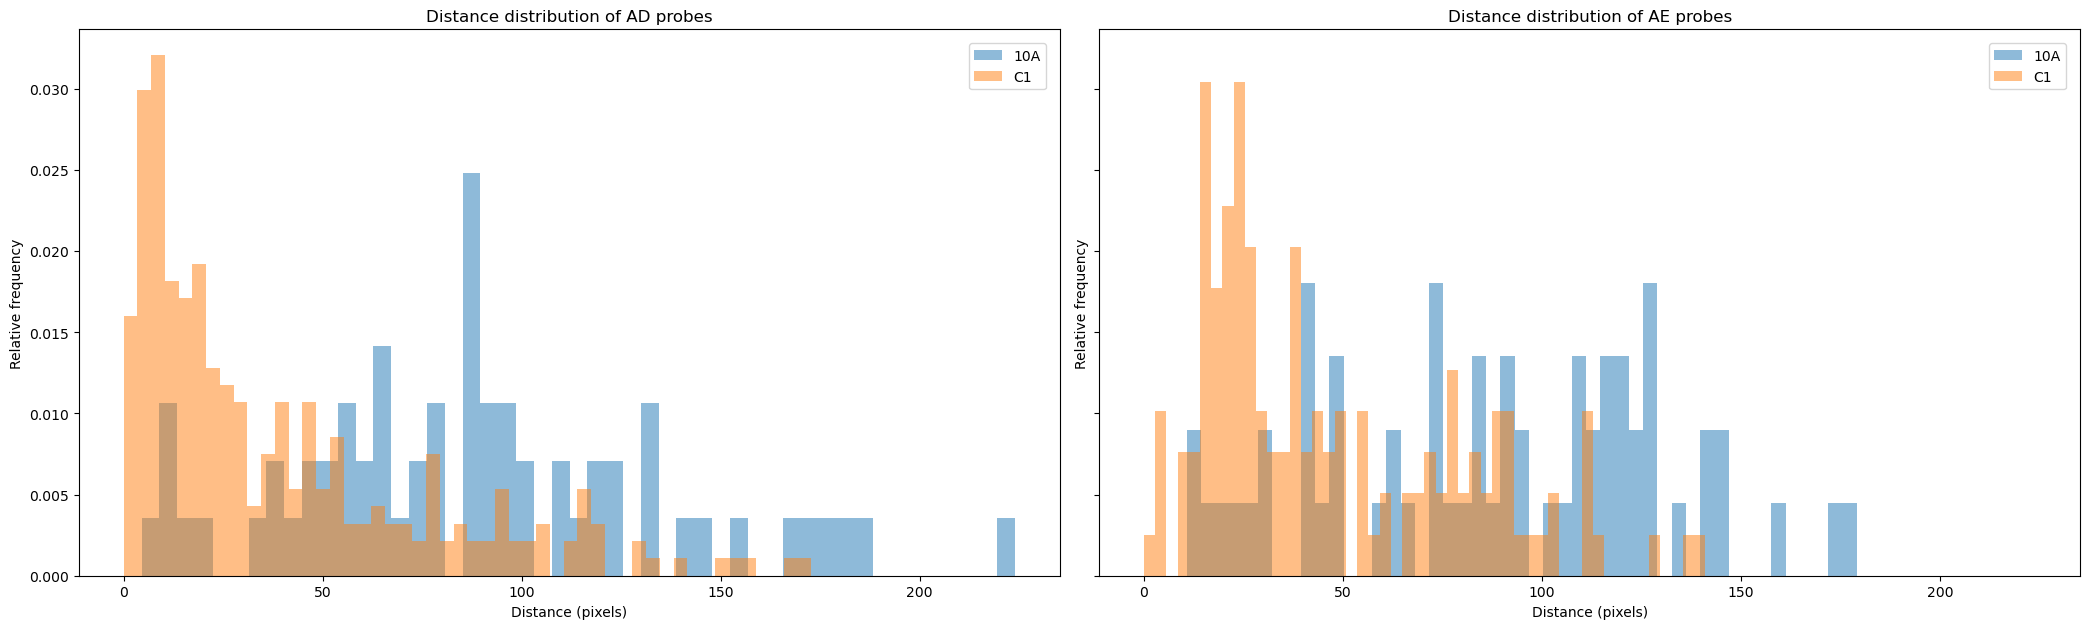

In [4]:
df1 = import_data("../data/output/fish/blobs/MCF10A_WT_AD.blobs.tsv.gz", 2)
df2 = import_data("../data/output/fish/blobs/MCF10A_C1_AD.blobs.tsv.gz", 2)
df3 = import_data("../data/output/fish/blobs/MCF10A_WT_AE.blobs.tsv.gz", 2)
df4 = import_data("../data/output/fish/blobs/MCF10A_C1_AE.blobs.tsv.gz", 2)

fig, axs = plt.subplots(1, 2, figsize=(21, 6.4), sharex=True, sharey=True)

plot_distance_distribution(df1, axs[0], "10A", xmin=0)
plot_distance_distribution(df2, axs[0], "C1", xmin=0)

plot_distance_distribution(df3, axs[1], "10A", xmin=0)
plot_distance_distribution(df4, axs[1], "C1", xmin=0)


axs[0].set(title="Distance distribution of AD probes")

axs[1].set(title="Distance distribution of AE probes")

for ax in axs:
    ax.set(xlabel="Distance (pixels)", ylabel="Relative frequency")

fig.tight_layout()
_ = axs[0].legend(loc="upper right", borderaxespad=1)
_ = axs[1].legend(loc="upper right", borderaxespad=1)
fig.savefig("/tmp/fish_distances_hist.svg")

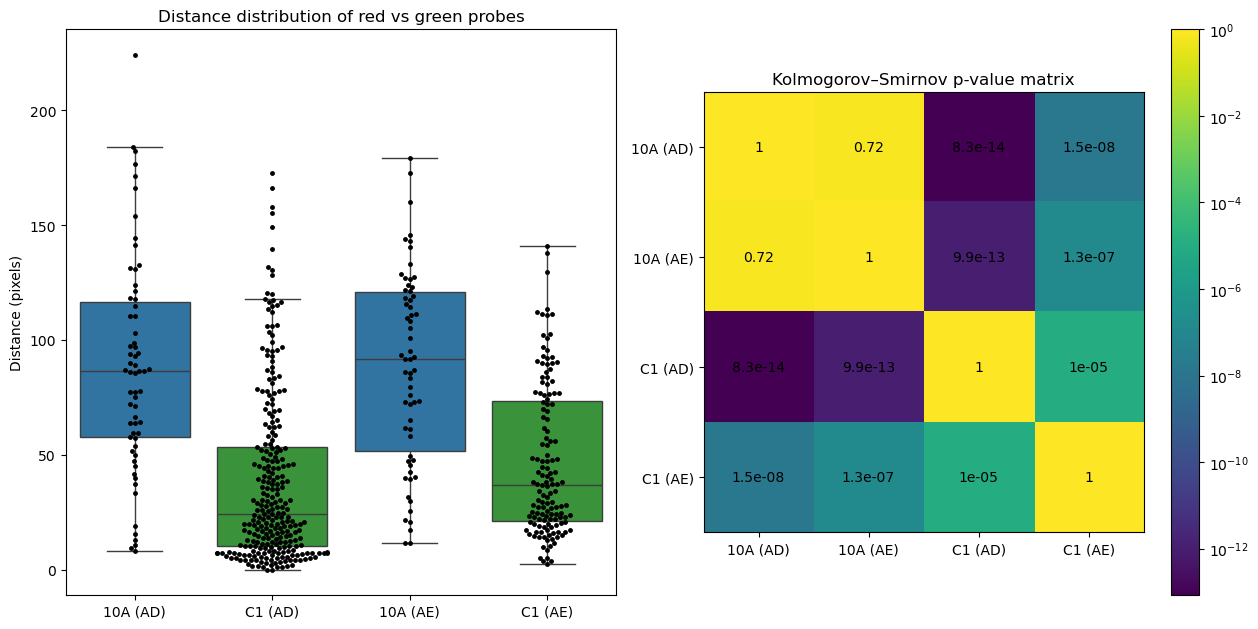

In [5]:
df1 = import_data("../data/output/fish/blobs/MCF10A_WT_AD.blobs.tsv.gz", 2)
df2 = import_data("../data/output/fish/blobs/MCF10A_C1_AD.blobs.tsv.gz", 2)
df3 = import_data("../data/output/fish/blobs/MCF10A_WT_AE.blobs.tsv.gz", 2)
df4 = import_data("../data/output/fish/blobs/MCF10A_C1_AE.blobs.tsv.gz", 2)

fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4))

dff = plot_distance_distribution_boxplot(df1, df2, df3, df4, axs[0], "10A (AD)", "C1 (AD)", "10A (AE)", "C1 (AE)")

df_pval = compute_pvalue_matrix(dff)
plot_pvalue_matrix(df_pval, axs[1])

axs[0].set(title="Distance distribution of red vs green probes")
axs[1].set(title="Kolmogorov–Smirnov p-value matrix")

fig.tight_layout()
fig.savefig("/tmp/fish_distances_boxplot.svg")
df_pval.to_csv("/tmp/fish_distances_pvalues.tsv.gz", sep="\t", index=False)

obs = dff.groupby("condition").size().to_frame().rename(columns={0: "observations"}).reset_index()
obs.to_csv("/tmp/fish_distances_nobs.tsv.gz", sep="\t", index=False)

## Distribution of the shorted distance between red and green blobs in a given nucleus

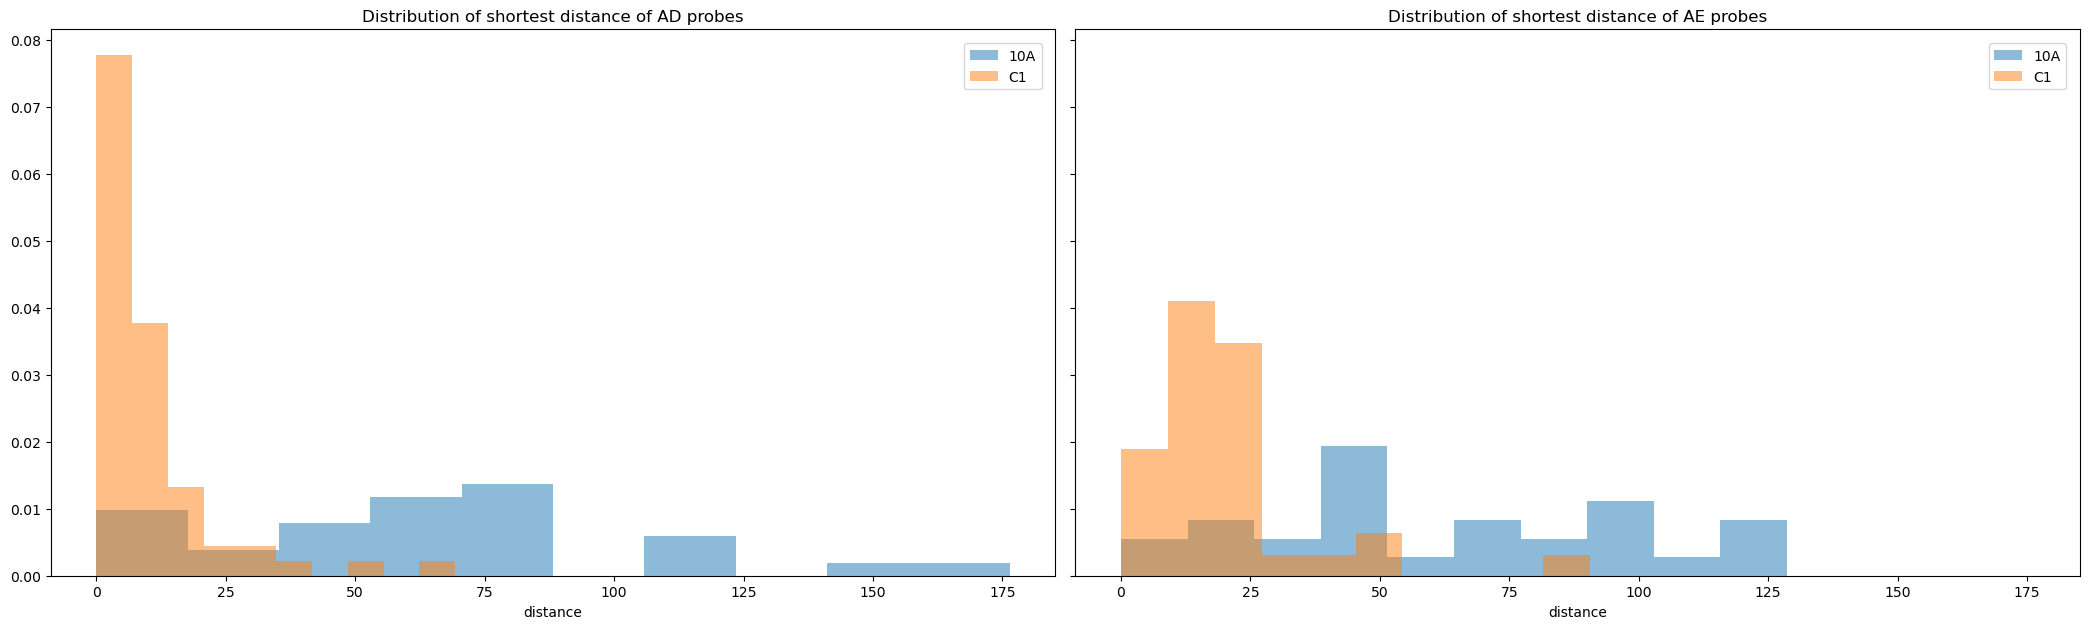

In [6]:
df1 = import_data("../data/output/fish/blobs/MCF10A_WT_AD.blobs.tsv.gz", 2)
df2 = import_data("../data/output/fish/blobs/MCF10A_C1_AD.blobs.tsv.gz", 2)
df3 = import_data("../data/output/fish/blobs/MCF10A_WT_AE.blobs.tsv.gz", 2)
df4 = import_data("../data/output/fish/blobs/MCF10A_C1_AE.blobs.tsv.gz", 2)

fig, axs = plt.subplots(1, 2, figsize=(21, 6.4), sharex=True, sharey=True)

dff1 = plot_min_distance_distribution(df1, axs[0], "10A", xmin=0)
dff2 = plot_min_distance_distribution(df2, axs[0], "C1", xmin=0)

dff1 = plot_min_distance_distribution(df3, axs[1], "10A", xmin=0)
dff2 = plot_min_distance_distribution(df4, axs[1], "C1", xmin=0)

axs[0].set(title="Distribution of shortest distance of AD probes")

tt = scipy.stats.ttest_ind(df3["distance"], df4["distance"])
kt = scipy.stats.kstest(df3["distance"], df4["distance"])
axs[1].set(title="Distribution of shortest distance of AE probes")

for ax in axs:
    ax.set(xlabel="distance")

fig.tight_layout()
_ = axs[0].legend(loc="upper right", borderaxespad=1)
_ = axs[1].legend(loc="upper right", borderaxespad=1)
fig.savefig("/tmp/fish_shortest_distance_hist.svg")

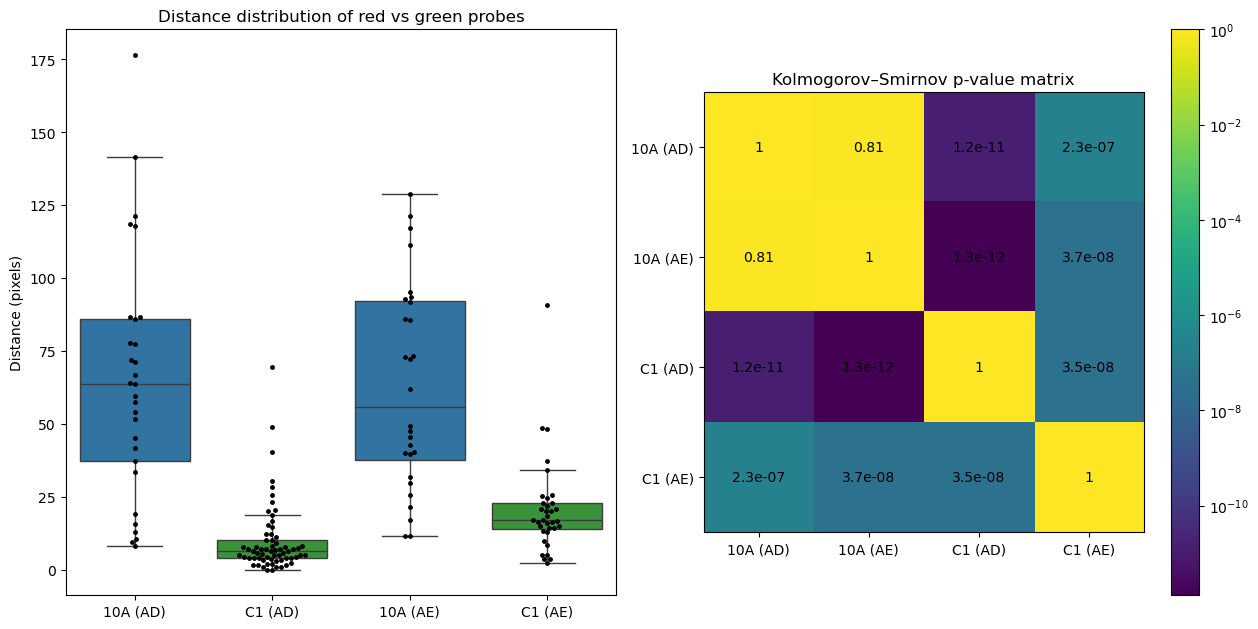

In [7]:
df1 = import_data("../data/output/fish/blobs/MCF10A_WT_AD.blobs.tsv.gz", 2)
df2 = import_data("../data/output/fish/blobs/MCF10A_C1_AD.blobs.tsv.gz", 2)
df3 = import_data("../data/output/fish/blobs/MCF10A_WT_AE.blobs.tsv.gz", 2)
df4 = import_data("../data/output/fish/blobs/MCF10A_C1_AE.blobs.tsv.gz", 2)


fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4))

dff = plot_min_distance_distribution_boxplot(df1, df2, df3, df4, axs[0], "10A (AD)", "C1 (AD)", "10A (AE)", "C1 (AE)")
df_pval = compute_pvalue_matrix(dff)
plot_pvalue_matrix(df_pval, axs[1])

axs[0].set(title="Distance distribution of red vs green probes")
axs[1].set(title="Kolmogorov–Smirnov p-value matrix")

fig.tight_layout()
fig.savefig("/tmp/fish_shortest_distance_boxplot.svg")
df_pval.to_csv("/tmp/fish_shortest_distance_pvalues.tsv.gz", sep="\t", index=False)

obs = dff.groupby("condition").size().to_frame().rename(columns={0: "observations"}).reset_index()
obs.to_csv("/tmp/fish_shortest_distance_nobs.tsv.gz", sep="\t", index=False)